<a href="https://colab.research.google.com/github/soumik12345/point-cloud-segmentation/blob/dataloader/notebooks/pointnet_shapenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
dataset_url = 'https://github.com/soumik12345/point-cloud-segmentation/releases/download/v0.1/shapenet.zip'

dataset_path = tf.keras.utils.get_file(
    fname='shapenet.zip', origin=dataset_url,
    cache_subdir='datasets', hash_algorithm='auto',
    extract=True, archive_format='auto', cache_dir='datasets'
)

In [3]:
with open('/tmp/.keras/datasets/PartAnnotation/metadata.json') as json_file:
    metadata = json.load(json_file)

metadata

{'Airplane': {'colors': ['blue', 'green', 'red', 'pink'],
  'directory': '02691156',
  'lables': ['wing', 'body', 'tail', 'engine']},
 'Bag': {'colors': ['blue', 'green'],
  'directory': '02773838',
  'lables': ['handle', 'body']},
 'Cap': {'colors': ['blue', 'green'],
  'directory': '02954340',
  'lables': ['panels', 'peak']},
 'Car': {'colors': ['blue', 'green', 'red'],
  'directory': '02958343',
  'lables': ['wheel', 'hood', 'roof']},
 'Chair': {'colors': ['blue', 'green', 'red', 'pink'],
  'directory': '03001627',
  'lables': ['leg', 'arm', 'back', 'seat']},
 'Earphone': {'colors': ['blue', 'green'],
  'directory': '03261776',
  'lables': ['earphone', 'headband']},
 'Guitar': {'colors': ['blue', 'green', 'red'],
  'directory': '03467517',
  'lables': ['head', 'body', 'neck']},
 'Knife': {'colors': ['blue', 'green'],
  'directory': '03624134',
  'lables': ['handle', 'blade']},
 'Lamp': {'colors': ['blue', 'green', 'red'],
  'directory': '03636649',
  'lables': ['canopy', 'lampshade'

In [4]:
points_dir = '/tmp/.keras/datasets/PartAnnotation/{}/points'.format(metadata['Airplane']['directory'])
labels_dir = '/tmp/.keras/datasets/PartAnnotation/{}/points_label'.format(metadata['Airplane']['directory'])
LABELS = metadata['Airplane']['lables']
COLORS = metadata['Airplane']['colors']
VAL_SPLIT = 0.2
N_SAMPLE_POINTS = 1024

In [5]:
points_files = glob(os.path.join(points_dir, '*.pts'))

In [6]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    file_id = point_file.split('/')[-1].split('.')[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + '.seg')
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype('float32')
            num_labels = len(label_data[label])
    try:
        label_map = ['none'] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = np.vstack(
            tuple([label_data[key] for key in LABELS]))
        point_clouds.append(point_cloud)
        point_cloud_labels.append(
            label_data.reshape(
                label_data.shape[1], label_data.shape[0]))
        all_labels.append(label_map)
    except KeyError:
        # Use point cloud files without labels as test data
        test_point_clouds.append(point_cloud)

100%|██████████| 4045/4045 [05:19<00:00, 12.67it/s]


`point_clouds` is basically a list of np.array that represents the point cloud data in the form of x, y and z coordinate. The axis 0 represents the number of points the ith point cloud has while the axis 1 represents the coordinates. `all_labels` is the list that represent the label of each coordinate at a string and is needed mainly for visualization purposes.

`test_point_clouds` are in the same format as `point_clouds`, just that they don't have correspoint labels associated with them.

`point_cloud_labels` is basically a list of np.array that represents the point cloud labels for each coordinate in one-hot encoded form corresponding to the `point_clouds` list. The axis 0 represents the number of points the ith point cloud has while the axis 1 represents the one-hot encoded labels for that particular coordinate.

In [7]:
for _ in range(10):
    i = random.randint(0, len(point_clouds) - 1)
    print(f'point_clouds[{i}].shape:', point_clouds[0].shape)
    print(f'point_cloud_labels[{i}].shape:', point_cloud_labels[0].shape)
    print(f'all_labels[{i}][:5]:', all_labels[i][:5], '\n')

point_clouds[2412].shape: (2465, 3)
point_cloud_labels[2412].shape: (2465, 4)
all_labels[2412][:5]: ['wing', 'body', 'wing', 'tail', 'wing'] 

point_clouds[2075].shape: (2465, 3)
point_cloud_labels[2075].shape: (2465, 4)
all_labels[2075][:5]: ['body', 'tail', 'body', 'body', 'body'] 

point_clouds[2810].shape: (2465, 3)
point_cloud_labels[2810].shape: (2465, 4)
all_labels[2810][:5]: ['engine', 'engine', 'body', 'tail', 'engine'] 

point_clouds[658].shape: (2465, 3)
point_cloud_labels[658].shape: (2465, 4)
all_labels[658][:5]: ['engine', 'tail', 'tail', 'body', 'body'] 

point_clouds[797].shape: (2465, 3)
point_cloud_labels[797].shape: (2465, 4)
all_labels[797][:5]: ['engine', 'body', 'body', 'body', 'wing'] 

point_clouds[1184].shape: (2465, 3)
point_cloud_labels[1184].shape: (2465, 4)
all_labels[1184][:5]: ['body', 'wing', 'wing', 'wing', 'wing'] 

point_clouds[667].shape: (2465, 3)
point_cloud_labels[667].shape: (2465, 4)
all_labels[667][:5]: ['tail', 'wing', 'wing', 'tail', 'tail'] 

In [8]:
def visualize_data_plotly(point_cloud, labels):
    fig = px.scatter_3d(
        pd.DataFrame(
            data={
                'x': point_cloud[:, 0],
                'y': point_cloud[:, 1],
                'z': point_cloud[:, 2],
                'label': labels
            }
        ), x="x", y="y", z="z",
        color="label", labels={"label": "Label"},
        color_discrete_sequence=COLORS,
        category_orders={"label": LABELS}
    )
    fig.show()

In [9]:
def visualize_data_plt(point_cloud, labels):
    df = pd.DataFrame(
        data={
            'x': point_cloud[:, 0],
            'y': point_cloud[:, 1],
            'z': point_cloud[:, 2],
            'label': labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')  
    for index, label in enumerate(LABELS):
        c_df = df[df['label'] == label]
        try:
            ax.scatter(
                c_df['x'], c_df['y'], c_df['z'],
                label=label, alpha = 0.5, c=COLORS[index]
            ) 
        except IndexError:
            pass
    ax.legend()
    plt.show()

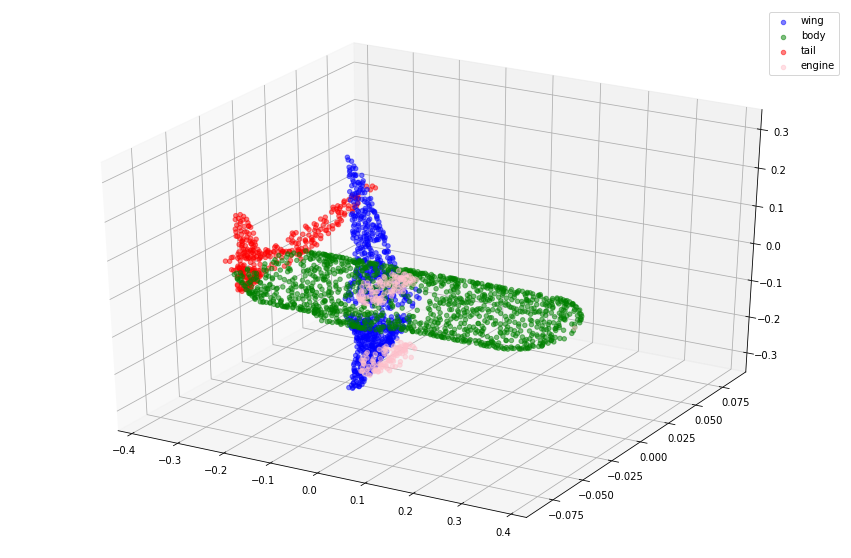

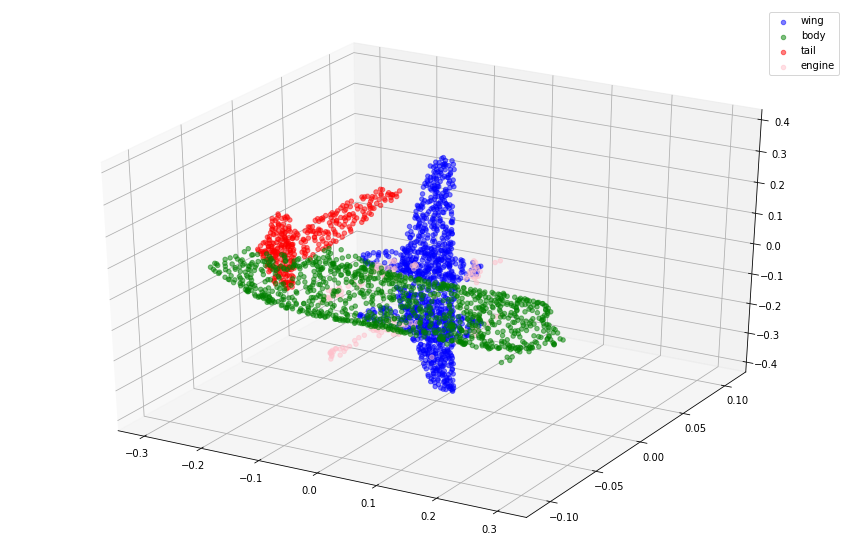

In [10]:
visualize_data_plt(point_clouds[0], all_labels[0])
visualize_data_plt(point_clouds[300], all_labels[300])

In [11]:
visualize_data_plotly(point_clouds[0], all_labels[0])
visualize_data_plotly(point_clouds[300], all_labels[300])

In [12]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    n_points = len(current_point_cloud)
    # Randomly sampling respective indices
    sampled_indices = random.sample(list(range(n_points)), N_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 3694/3694 [00:11<00:00, 323.51it/s]


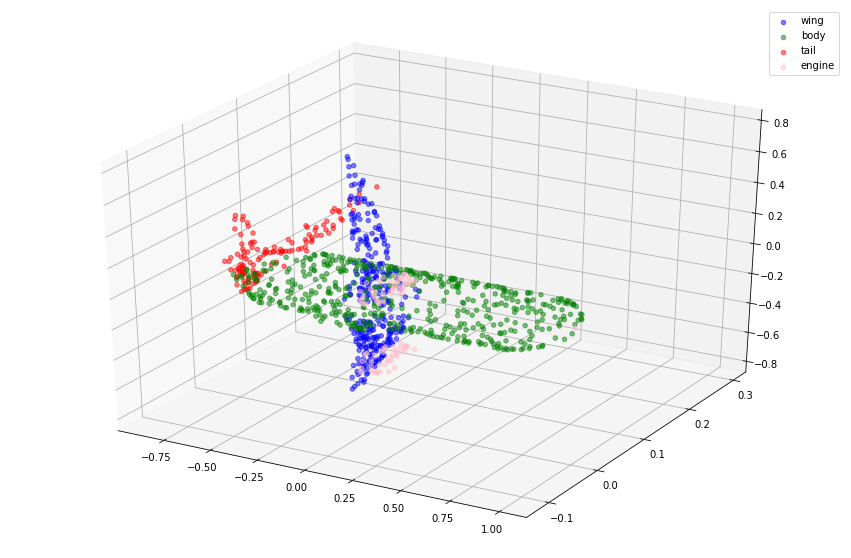

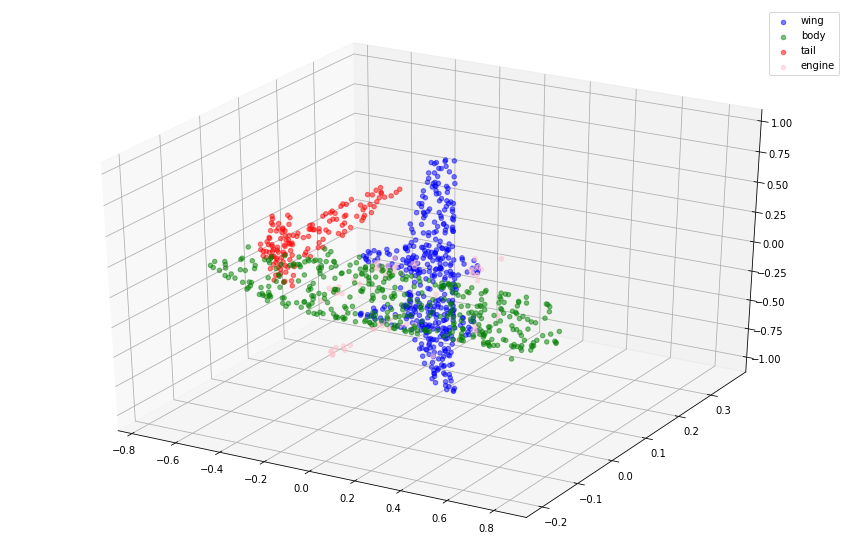

In [13]:
visualize_data_plt(point_clouds[0], all_labels[0])
visualize_data_plt(point_clouds[300], all_labels[300])

In [14]:
visualize_data_plotly(point_clouds[0], all_labels[0])
visualize_data_plotly(point_clouds[300], all_labels[300])

In [15]:
split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_point_cloud_labels = point_cloud_labels[:split_index]

val_point_clouds = point_clouds[split_index:]
val_point_cloud_labels = point_cloud_labels[split_index:]

print('Num train point clouds:', len(train_point_clouds))
print('Num train point cloud labels:', len(train_point_cloud_labels))
print('Num val point clouds:', len(val_point_clouds))
print('Num val point cloud labels:', len(val_point_cloud_labels))

Num train point clouds: 2955
Num train point cloud labels: 2955
Num val point clouds: 739
Num val point cloud labels: 739
